In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt

### Gerando valores
X é uma sequência de 0 até 1, incrementando em 0,02 [0.0, 0.02, 0.04]

y é 0.7 * X + bias

In [6]:
# Parâmetros conhecidos
weight = 0.7
bias = 0.3

# Criar dados
start = 0
end = 200000
step = 0.02

X = torch.arange(start=start, end=end, step=step, device="cuda").unsqueeze(dim=1)
y = weight * X + bias


X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]], device='cuda:0'),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]], device='cuda:0'))

In [7]:
train_split = int(0.8 * len(X)) # 80% do tamanho tensor X
# X_train, y_train = X[:train_split], y[:train_split] # não sei para que complicar assim
X_train = X[:train_split]
y_train = y[:train_split]

X_test = X[train_split:]
y_test = y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(8000000, 8000000, 2000000, 2000000)

### Plotar dados

In [4]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
    plt.figure(figsize=(5, 3.5))
    plt.scatter(train_data, train_labels, c="b", s=4, label="Dados de treinamento")
    plt.scatter(test_data, test_labels, c="g", s=4, label="Dados de teste")
    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")


    plt.legend(prop={"size":14})


KeyboardInterrupt



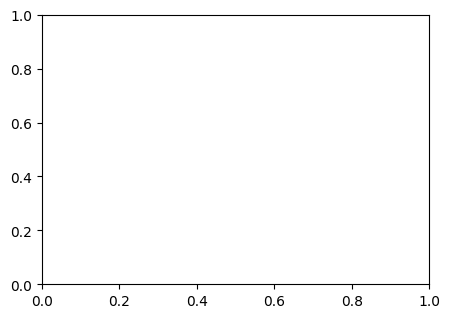

In [5]:
plot_predictions(X_train, y_train, X_test, y_test)

### Criar um modelo de regressão linear

In [8]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

## Criar uma instância da classe que representa o modelo

In [9]:
torch.manual_seed(42)

model_0 = LinearRegressionModelV2()
model_0.to("cuda")
list(model_0.parameters())

[Parameter containing:
 tensor([[0.7645]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.8300], device='cuda:0', requires_grad=True)]

### Realizando predições

In [10]:
with torch.inference_mode():
    y_preds = model_0(X_test)

RuntimeError: CUDA error: CUBLAS_STATUS_ALLOC_FAILED when calling `cublasCreate(handle)`

In [ ]:
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

In [ ]:
plot_predictions(predictions=y_preds)

In [ ]:
y_test - y_preds

### Treinando o modelo

In [27]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.1) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

In [28]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100000000

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10000 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.cpu().detach().numpy())
            test_loss_values.append(test_loss.cpu().detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 159740.515625 | MAE Test Loss: 3240569.25 
Epoch: 10000 | MAE Train Loss: 159740.5625 | MAE Test Loss: 3240569.25 
Epoch: 20000 | MAE Train Loss: 159740.5625 | MAE Test Loss: 3240569.25 
Epoch: 30000 | MAE Train Loss: 159740.578125 | MAE Test Loss: 3240569.25 
Epoch: 40000 | MAE Train Loss: 159740.578125 | MAE Test Loss: 3240569.25 
Epoch: 50000 | MAE Train Loss: 159740.578125 | MAE Test Loss: 3240569.25 
Epoch: 60000 | MAE Train Loss: 159740.59375 | MAE Test Loss: 3240569.25 


KeyboardInterrupt: 

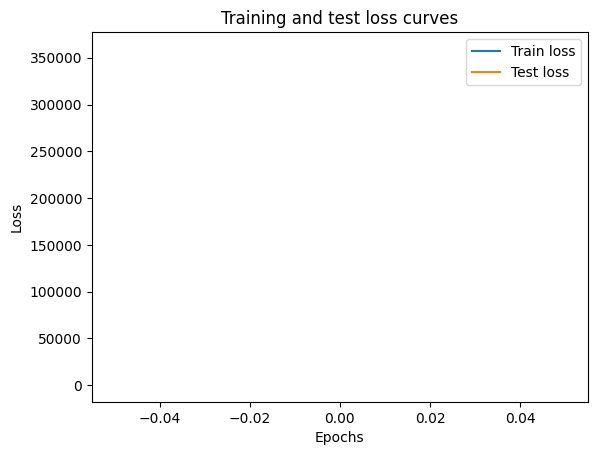

In [23]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [ ]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

### Inference

In [ ]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

In [ ]:
plot_predictions(predictions=y_preds)
